In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("Trojan_Detection.csv")

# Show shape and first few rows
print("Initial shape:", df.shape)
print(df.head())

Initial shape: (177482, 86)
   Unnamed: 0                                Flow ID    Source IP  \
0       73217    10.42.0.42-121.14.255.84-49975-80-6   10.42.0.42   
1       72089  172.217.6.226-10.42.0.42-443-49169-17   10.42.0.42   
2       96676       10.42.0.1-10.42.0.42-53-37749-17   10.42.0.42   
3       42891       10.42.0.1-10.42.0.42-53-41352-17   10.42.0.42   
4      169326  10.42.0.151-107.22.241.77-44353-443-6  10.42.0.151   

    Source Port  Destination IP   Destination Port   Protocol  \
0         49975   121.14.255.84                 80          6   
1         49169   172.217.6.226                443         17   
2         37749       10.42.0.1                 53         17   
3         41352       10.42.0.1                 53         17   
4         44353   107.22.241.77                443          6   

             Timestamp   Flow Duration   Total Fwd Packets  ...  \
0  17/07/2017 01:18:33        10743584                   4  ...   
1  17/07/2017 10:25:25          

In [2]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()
print(df.columns[:10])  # preview first 10 columns

Index(['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets'],
      dtype='object')


In [3]:
# Convert Timestamp to datetime if it exists
if "Timestamp" in df.columns:
    df["Timestamp_parsed"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["hour"] = df["Timestamp_parsed"].dt.hour
    df["dayofweek"] = df["Timestamp_parsed"].dt.dayofweek

/tmp/ipython-input-3804189183.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Timestamp_parsed"] = pd.to_datetime(df["Timestamp"], errors="coerce")


In [4]:
drop_cols = ["Unnamed: 0", "Flow ID", "Source IP", "Destination IP", "Timestamp"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
print("Shape after dropping identifiers:", df.shape)

Shape after dropping identifiers: (177482, 84)


In [6]:
df.isna().mean()

,0
Source Port,0.0
Destination Port,0.0
Protocol,0.0
Flow Duration,0.0
Total Fwd Packets,0.0
...,...
Idle Min,0.0
Class,0.0
Timestamp_parsed,0.0
hour,0.0


In [7]:
from sklearn.preprocessing import LabelEncoder

if "Class" in df.columns:
    if set(df["Class"].unique()) == {"Benign", "Trojan"}:
        df["Class"] = df["Class"].map({"Benign": 0, "Trojan": 1})
    else:
        le = LabelEncoder()
        df["Class"] = le.fit_transform(df["Class"])

print(df["Class"].value_counts())

Class
1    90683
0    86799
Name: count, dtype: int64


In [8]:
df = pd.get_dummies(df, drop_first=True)
print("Final shape after preprocessing:", df.shape)

Final shape after preprocessing: (177482, 84)


/tmp/ipython-input-3420206846.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Class", data=df, palette="Set2")


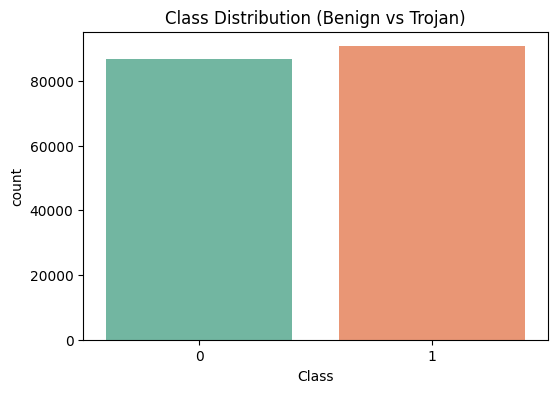

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="Class", data=df, palette="Set2")
plt.title("Class Distribution (Benign vs Trojan)")
plt.show()

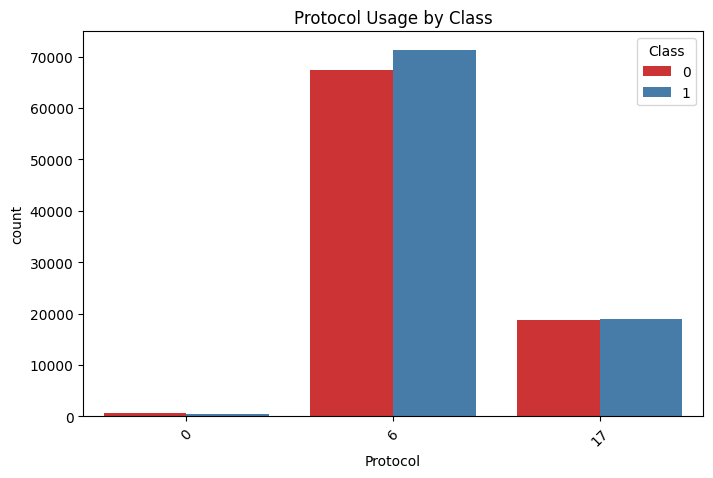

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(x="Protocol", hue="Class", data=df, palette="Set1")
plt.title("Protocol Usage by Class")
plt.xticks(rotation=45)
plt.show()

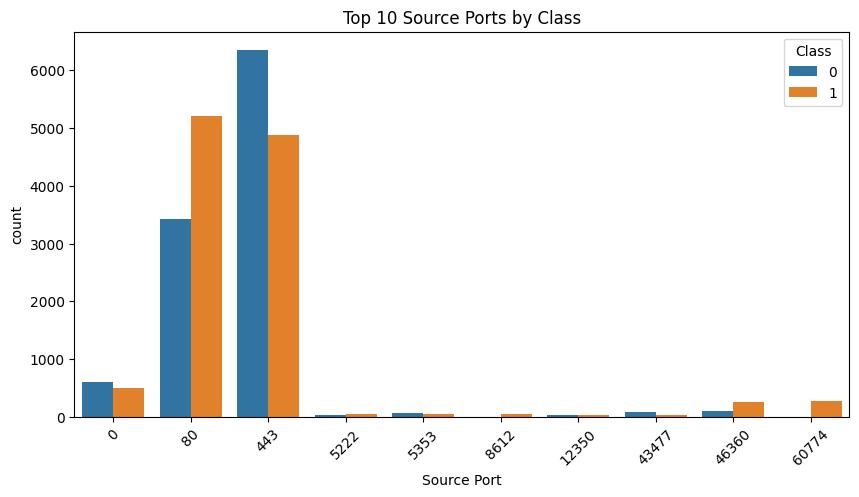

In [16]:
plt.figure(figsize=(10,5))
top_src_ports = df["Source Port"].value_counts().nlargest(10).index
sns.countplot(x="Source Port", hue="Class", data=df[df["Source Port"].isin(top_src_ports)])
plt.title("Top 10 Source Ports by Class")
plt.xticks(rotation=45)
plt.show()

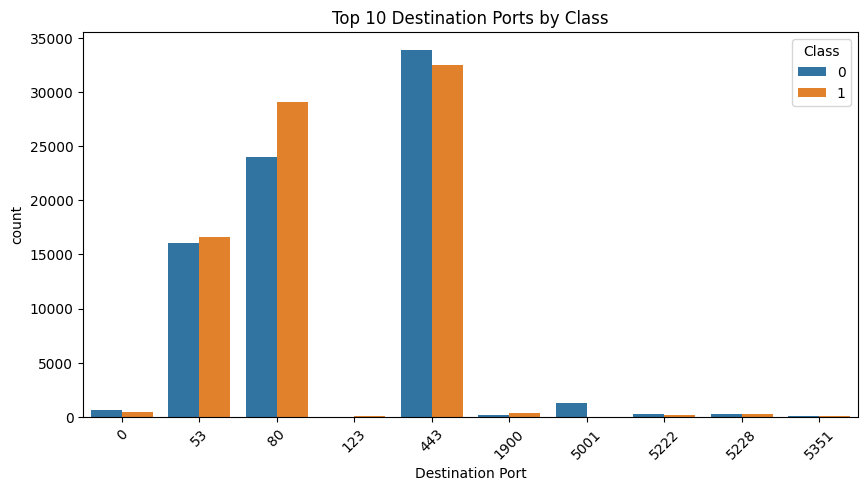

In [18]:
plt.figure(figsize=(10,5))
top_dst_ports = df["Destination Port"].value_counts().nlargest(10).index
sns.countplot(x="Destination Port", hue="Class", data=df[df["Destination Port"].isin(top_dst_ports)])
plt.title("Top 10 Destination Ports by Class")
plt.xticks(rotation=45)
plt.show()

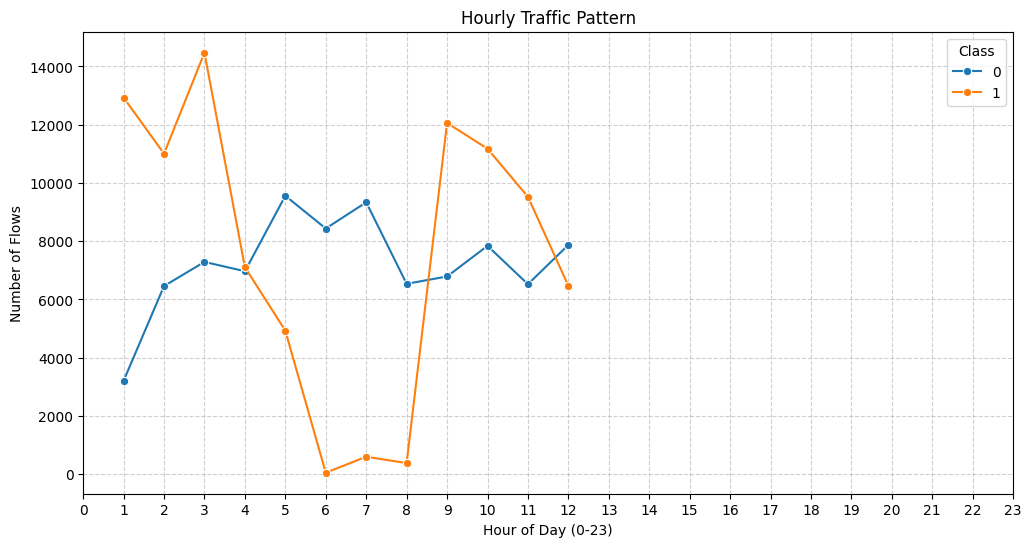

In [32]:
# Aggregate hourly counts
hourly_line = df.groupby(["hour", "Class"]).size().reset_index(name="count")

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_line, x="hour", y="count", hue="Class", marker="o")

plt.title("Hourly Traffic Pattern")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Number of Flows")
plt.xticks(range(0,24))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Class")
plt.show()

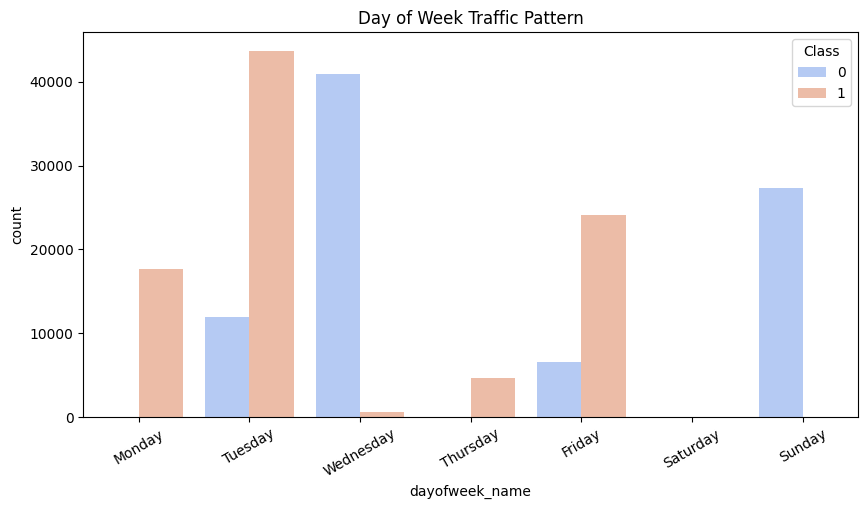

In [28]:
day_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday",
           3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

df["dayofweek_name"] = df["dayofweek"].map(day_map)
plt.figure(figsize=(10,5))
sns.countplot(x="dayofweek_name", hue="Class", data=df,
              order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
              palette="coolwarm")
plt.title("Day of Week Traffic Pattern")
plt.xticks(rotation=30)
plt.show()

🔹 Random Forest Report
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     26040
           1       0.95      0.97      0.96     27205

    accuracy                           0.96     53245
   macro avg       0.96      0.95      0.96     53245
weighted avg       0.96      0.96      0.96     53245

🔹 Gradient Boosting Report
              precision    recall  f1-score   support

           0       0.99      0.90      0.95     26040
           1       0.91      0.99      0.95     27205

    accuracy                           0.95     53245
   macro avg       0.95      0.95      0.95     53245
weighted avg       0.95      0.95      0.95     53245



<Figure size 800x600 with 0 Axes>

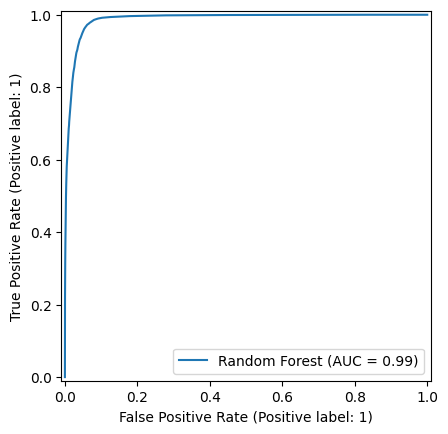

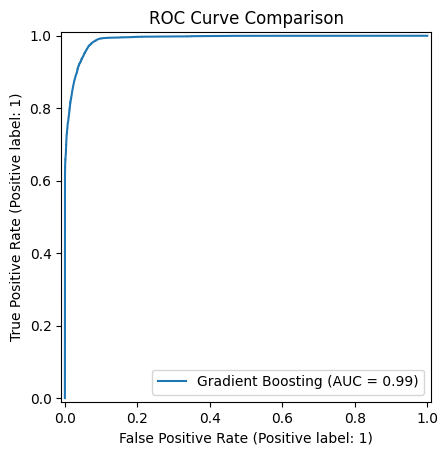

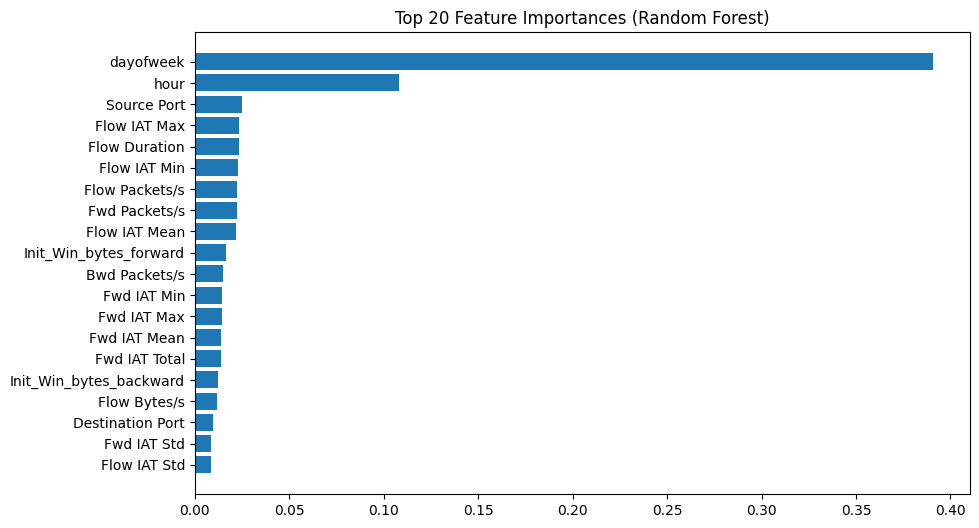

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

# --------------------------
# 1. Split Data
# --------------------------
X = df.drop(columns=["Class", "Timestamp", "Timestamp_parsed", "dayofweek_name"], errors="ignore")
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --------------------------
# 2. Feature Scaling (for LR, optional for trees)
# --------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# 3. Random Forest
# --------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🔹 Random Forest Report")
print(classification_report(y_test, y_pred_rf))

# --------------------------
# 4. Gradient Boosting
# --------------------------
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("🔹 Gradient Boosting Report")
print(classification_report(y_test, y_pred_gb))

# --------------------------
# 5. ROC Curve for comparison
# --------------------------
plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(gb, X_test, y_test, name="Gradient Boosting")
plt.title("ROC Curve Comparison")
plt.show()

# --------------------------
# 6. Feature Importance (from RF)
# --------------------------
importances = rf.feature_importances_
feat_names = X.columns
feat_imp = sorted(zip(feat_names, importances), key=lambda x: x[1], reverse=True)[:20]

plt.figure(figsize=(10,6))
plt.barh([f[0] for f in feat_imp], [f[1] for f in feat_imp])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()